In [264]:
import gensim
import numpy as np
import pandas as pd
import os
import re
import csv
import codecs
import sys
import pickle

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

from keras import callbacks
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import concatenate,Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from IPython.display import Image
import pydot
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import tensorflow as tf

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
sess = tf.Session(config=tf_config)



from nltk.stem import SnowballStemmer

from string import punctuation

from keras import backend as K
from keras.engine.topology import Layer
#from keras import initializations
from keras import initializers, regularizers, constraints


In [294]:
# Specify the folder locations
#W2V_DIR = './data/GoogleNews-vectors-negative300.bin' #
GloVe_DIR = './data/glove.twitter.27B.50d.txt'
#the data directory
DATA_DIR = './data'
# These are some hyperparameters that can be tuned
MAX_SENT_LEN_HEAD = 15 
MAX_SENT_LEN_BODY = 75 #75(0.68), 150, 300 700(90% but too time comsuming)
MAX_VOCAB_SIZE = 40000 #vocabulary
LSTM_DIM = 100 #units
EMBEDDING_DIM = 50 #50 for GloVe 300 for w2v
BATCH_SIZE = 128
N_EPOCHS = 40 #40


In [295]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)

In [296]:
# Read the text files of fnc data
bodies = pd.read_csv(DATA_DIR + '/body_table.csv')
    
train_df = pd.read_csv(DATA_DIR + '/train_data.csv')

#validation_df = pd.read_csv(DATA_DIR + '/validation_data.csv')


test_df = pd.read_csv(DATA_DIR + '/test_data.csv')

In [297]:
train_df.replace('unrelated',0,True)
train_df.replace('agree',1,True)
train_df.replace('disagree',2,True)
train_df.replace('discuss',3,True)
# validation_df.replace('unrelated',0,True)
# validation_df.replace('agree',1,True)
# validation_df.replace('disagree',2,True)
# validation_df.replace('discuss',3,True)
test_df.replace('unrelated',0,True)
test_df.replace('agree',1,True)
test_df.replace('disagree',2,True)
test_df.replace('discuss',3,True)

In [298]:
combine_df_train = train_df.join(bodies.set_index('Body ID'), on='Body ID')
#combine_df_vali = validation_df.join(bodies.set_index('Body ID'), on='Body ID')
combine_df_test = test_df.join(bodies.set_index('Body ID'), on='Body ID')

In [299]:
# Pre-processing involves removal of puctuations and converting text to lower case
word_seq_head_train = [text_to_word_sequence(head) for head in combine_df_train['Headline']]
word_seq_bodies_train = [text_to_word_sequence(body) for body in combine_df_train['articleBody']]

In [300]:
word_seq_head_test = [text_to_word_sequence(head) for head in combine_df_test['Headline']]
word_seq_bodies_test = [text_to_word_sequence(body) for body in combine_df_test['articleBody']]

In [301]:
word_seq_head_train[6365]

['israeli',
 'report',
 'sisi',
 'offered',
 'abbas',
 'a',
 'palestinian',
 'state',
 'in',
 'sinai']

In [302]:
word_seq_bodies_train[6365]

['microsoft', 'will', 'buy', 'mojang', 'ab']

# one tokenizer


In [303]:
word_seq = []

for i in range(len(word_seq_head_train)):
    word_seq.append(word_seq_head_train[i])
for i in range(len(word_seq_bodies_train)):
    word_seq.append(word_seq_bodies_train[i])


for i in range(len(word_seq_head_test)):
    word_seq.append(word_seq_head_test[i])
for i in range(len(word_seq_bodies_test)):
    word_seq.append(word_seq_bodies_test[i])



In [304]:
filter_list = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters=filter_list)
tokenizer.fit_on_texts([seq for seq in word_seq])

print("Number of words in vocabulary:", len(tokenizer.word_index))

Number of words in vocabulary: 35375


In [305]:
word_seq_head_train[6365]

['israeli',
 'report',
 'sisi',
 'offered',
 'abbas',
 'a',
 'palestinian',
 'state',
 'in',
 'sinai']

In [306]:
word_seq_bodies_train[6365]

['microsoft', 'will', 'buy', 'mojang', 'ab']

In [307]:
# Convert the sequence of words to sequnce of indices
X_train_HEAD = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN_HEAD]) for seq in word_seq_head_train])
# list of list; join is to extend the list
X_train_HEAD = pad_sequences(X_train_HEAD, maxlen=MAX_SENT_LEN_HEAD, padding='post', truncating='post')
# y has already to be convert to 1,0 sequence
X_train_BODY = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN_BODY]) for seq in word_seq_bodies_train])
print(X_train_BODY[6365])
X_train_BODY = pad_sequences(X_train_BODY, maxlen=MAX_SENT_LEN_BODY, padding='post', truncating='post')
print(X_train_BODY[6365])
y_train = combine_df_train['Stance']
#finishing time: 1 min

[1211, 39, 1186, 3160, 15538]
[ 1211    39  1186  3160 15538     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]


In [308]:
X_train_HEAD[6365]

array([ 661,   98, 3830, 1111, 4152,    3, 2870,   53,    5, 2670,    0,
          0,    0,    0,    0], dtype=int32)

In [309]:
X_train_BODY[6365]

array([ 1211,    39,  1186,  3160, 15538,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=int32)

In [310]:
# Convert the sequence of words to sequnce of indices
X_test_HEAD = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN_HEAD]) for seq in word_seq_head_test])
# list of list; join is to extend the list
X_test_HEAD = pad_sequences(X_test_HEAD, maxlen=MAX_SENT_LEN_HEAD, padding='post', truncating='post')
# y has already to be convert to 1,0 sequence
X_test_BODY = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN_BODY]) for seq in word_seq_bodies_test])
X_test_BODY = pad_sequences(X_test_BODY, maxlen=MAX_SENT_LEN_BODY, padding='post', truncating='post')
#finishing time: 1 min

In [311]:
#encode class values as integers
encoder_train = LabelEncoder()
encoder_train.fit(y_train)
encoded_train = encoder_train.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_train)

In [312]:
X_train_HEAD, X_vali_HEAD, X_train_BODY, X_vali_BODY, y_train, y_vali = train_test_split(X_train_HEAD,X_train_BODY, dummy_y_train, random_state=10, test_size=0.1)

In [313]:
#GloVes Load
glove_input_file = GloVe_DIR
word2vec_output_file = 'glove.50d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
embeddings = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [314]:
# Create an embedding matrix containing only the word's in our vocabulary
# If the word does not have a pre-trained embedding, then randomly initialize the embedding
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0
for word, i in tokenizer.word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
        #word 是sentence里的
        #none: if sentence里的word没有对应的pre-trained embedding 那么就有keyerror了
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        #如果存在pre-trained word embedding，那么把这个embedding给到embedding_matrix里
        #embeddings_matrix的第i行对应Wi
        
del embeddings
#delete

# Building Model

In [315]:
headline_embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embeddings_matrix],
                            input_length=MAX_SENT_LEN_HEAD,
                            trainable=True,mask_zero=True)


In [316]:
headline_sequence_input = Input(shape=(MAX_SENT_LEN_HEAD,))
embedded_headline = headline_embedding_layer(headline_sequence_input)
headline_lstm = LSTM(100, recurrent_dropout = 0.8, return_sequences = True, return_state = True)
encoder_outputs, state_h, state_c = headline_lstm(embedded_headline)
#encoder_outputs for attention Y
encoder_states = [state_h, state_c]



In [317]:
article_embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embeddings_matrix],
                            input_length=MAX_SENT_LEN_BODY,
                            trainable=True,mask_zero=True)

In [318]:
article_sequence_input = Input(shape=(MAX_SENT_LEN_BODY,))
embedded_article = article_embedding_layer(article_sequence_input)
article_lstm = LSTM(100, return_sequences = True)
encoded_article = article_lstm(embedded_article,initial_state=encoder_states)
encoded_article = Dropout(.8)(encoded_article)

In [319]:
#only attend first 15 states

class Attention(Layer):
    def __init__(self, attention_length = 15 ,
                 W_regularizer=None, 
                 W_constraint=None, 
                  **kwargs):

        #self.supports_masking = True
        #Xavier uniform initializer
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)

        self.W_constraint = constraints.get(W_constraint)

        self.attention_length = 15
        self.features_dim = 100 
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):        
        
        self.Wy = self.add_weight((self.features_dim,self.features_dim),
                                 initializer=self.init,
                                 name='{}_Wy'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        

        
        self.Wh = self.add_weight((self.features_dim,self.features_dim),
                                     initializer=self.init,
                                     name='{}_Wh'.format(self.name),
                                     regularizer=self.W_regularizer,
                                     constraint=self.W_constraint)

        self.w = self.add_weight((self.features_dim,1),
                                     initializer=self.init,
                                     name='{}_x'.format(self.name),
                                     regularizer=self.W_regularizer,
                                     constraint=self.W_constraint)

        self.Wp = self.add_weight((self.features_dim,self.features_dim),
                                     initializer=self.init,
                                     name='{}_Wp'.format(self.name),
                                     regularizer=self.W_regularizer,
                                     constraint=self.W_constraint)
        
        self.Wx = self.add_weight((self.features_dim,self.features_dim),
                                     initializer=self.init,
                                     name='{}_Wx'.format(self.name),
                                     regularizer=self.W_regularizer,
                                     constraint=self.W_constraint)

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        
        #x is a list containing the output hidden layers of first LSTM(), and the final state of seconde LSTM(body)
        Y_states = tf.slice(x[0], begin = [0, 0, 0], size = [-1, self.attention_length, -1]) #outputs of headline states
        h_state = x[1][:,-1,:] #output state of article lstm
        print ("Y_states", Y_states.shape)
        print ("h_state",h_state.shape)
        
        features_dim = self.features_dim
       

        M1 = K.reshape(K.dot(K.reshape(Y_states, (-1, features_dim)), self.Wy),shape = (-1,self.attention_length,features_dim ))
        M2 = K.expand_dims(K.dot(h_state, self.Wh),axis=1)
        M = K.tanh(M1+M2)
        alpha = K.reshape(K.softmax(K.dot(K.reshape(M, shape = (-1, features_dim)), self.w)), shape = (-1, self.attention_length))
        r = tf.squeeze(tf.matmul(tf.transpose(tf.expand_dims(alpha, 2), perm = [0, 2, 1]), Y_states))
        h_star = tf.tanh(tf.matmul(r, self.Wp) + tf.matmul(h_state, self.Wx))
        

        return h_star

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim
        


In [321]:
AttentionLayer = Attention()
attention_res = AttentionLayer([encoder_outputs, encoded_article] )
#panelLay = Dense(16, kernel_regularizer=regularizers.l2(0.1), activation='relu')(attention_res)
preds = Dense(4, activation='softmax')(attention_res)

Y_states (?, 15, 100)
h_state (?, 100)


In [322]:
#%%capture history
model = Model(inputs=[ headline_sequence_input,article_sequence_input], outputs=preds)
optimizer = optimizers.Adam(lr=0.001) # 
#add regularize
model.compile(optimizer-
              = optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy' ])

filepath="./result/conditional/Mask_Condition_Attention__epoch40_lr0.001_trainable_15Atlength_75_{epoch:02d}_{val_acc:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_acc', 
                                       verbose=0, 
                                       save_best_only=True)

callbacks_list = [checkpoint]

history = model.fit([X_train_HEAD, X_train_BODY], y_train, validation_data = ([ X_vali_HEAD,X_vali_BODY], y_vali), batch_size=BATCH_SIZE, epochs=N_EPOCHS,callbacks = callbacks_list)


Train on 60009 samples, validate on 6668 samples
Epoch 1/40
60009/60009 [==============================] - 69s 1ms/step - loss: 0.7725 - acc: 0.7278 - val_loss: 0.6658 - val_acc: 0.7545


/home/zqing/Projects/tf-sandbox/lib64/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_28 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_27/while/Exit_3:0' shape=(?, 100) dtype=float32>, <tf.Tensor 'lstm_27/while/Exit_4:0' shape=(?, 100) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/40
60009/60009 [==============================] - 62s 1ms/step - loss: 0.6037 - acc: 0.7630 - val_loss: 0.5005 - val_acc: 0.8020
Epoch 3/40
60009/60009 [==============================] - 62s 1ms/step - loss: 0.4665 - acc: 0.8104 - val_loss: 0.3991 - val_acc: 0.8422
Epoch 4/40
60009/60009 [==============================] - 62s 1ms/step - loss: 0.3842 - acc: 0.8443 - val_loss: 0.3530 - val_acc: 0.8661
Epoch 5/40
60009/60009 [==============================] - 62s 1ms/step - loss: 0.3265 - acc: 0.8684 - val_loss: 0.3076 - val_acc: 0.8839
Epoch 6/40
60009/60009 [==============================] - 62s 1ms/step - loss: 0.2777 - acc: 0.8902 - val_loss: 0.2696 - val_acc: 0.8992
Epoch 7/40
60009/60009 [==============================] - 62s 1ms/step - loss: 0.2423 - acc: 0.9039 - val_loss: 0.2551 - val_acc: 0.9018
Epoch 8/40
60009/60009 [==============================] - 62s 1ms/step - loss: 0.2094 - acc: 0.9168 - val_loss: 0.2434 - val_acc: 0.9100
Epoch 9/40
60009/60009 [=================

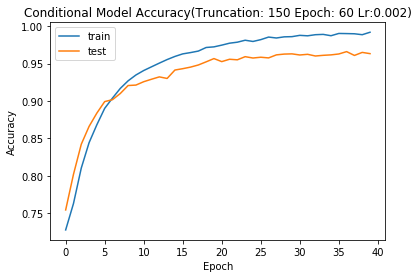

In [324]:
with open('./history/history(mask_conditional_epoch40_75_lr0.001_trainable)', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Conditional Model Accuracy(Truncation: 150 Epoch: 60 Lr:0.002)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')


# prdiction

In [176]:
from keras import models

In [177]:
model_file_path = './result/conditional/differentdata-FirstLSTMdropout0.8_Mask_Condition_Attention__epoch40_lr0.003_trainable_15Atlength_150_40_0.9475.h5'
model = models.load_model(model_file_path,custom_objects = {'Attention': Attention()})

Y_states (?, 15, 100)
h_state (?, 100)


In [178]:
preds = model.predict([X_test_HEAD,X_test_BODY])

In [179]:
preds

array([[9.9999988e-01, 2.3932689e-10, 1.1390582e-10, 1.3904284e-07],
       [9.9999821e-01, 2.2897855e-09, 2.1600366e-10, 1.8417825e-06],
       [1.2471218e-03, 9.2647976e-01, 7.1984977e-02, 2.8814224e-04],
       ...,
       [2.3019868e-01, 4.7908389e-04, 1.1402563e-02, 7.5791967e-01],
       [9.9997604e-01, 2.3959217e-05, 2.2579588e-08, 1.3820567e-08],
       [1.0000000e+00, 6.3416322e-10, 2.0205540e-10, 5.1331255e-09]],
      dtype=float32)

In [180]:
outputs = [np.argmax(p, axis = -1) for p in preds]

In [181]:
for i in range(len(outputs)):
    if outputs[i] == 0: outputs[i] = "unrelated"
    if outputs[i] == 1: outputs[i] = "disagree"
    if outputs[i] == 2: outputs[i] = "agree"
    if outputs[i] == 3: outputs[i] = "discuss"


In [182]:
df_predicted = pd.DataFrame({'Stance': outputs})
result = pd.concat([test_df, df_predicted], axis=1, sort=False)
result.to_csv('./different_conditional_150_answer.csv', index=False, encoding='utf-8')